In [0]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# !mkdir -p drive
# !google-drive-ocamlfuse drive

In [0]:
# !pip install keras
# !pip install datetime

In [0]:
import pandas as pd
import gc
import os
import numpy as np
import matplotlib.pyplot as plt
import time, datetime
from sklearn.linear_model import LogisticRegression
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, LSTM, concatenate, Reshape, Permute, MaxPooling2D
from keras import optimizers
from keras.utils import np_utils
from keras.models import Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
import scipy.io as sco
import seaborn as sns
%matplotlib inline

In [8]:
def get_file_paths(path):
  files = os.listdir(path)
  paths = []
  for f in files:
    print os.path.join(path, f)
    paths.append(os.path.join(path, f))

  return paths


get_file_paths('drive/DataSets/IJCAI-18/');

drive/DataSets/IJCAI-18/round1_ijcai_18_result_demo_20180301.txt
drive/DataSets/IJCAI-18/round1_ijcai_18_test_a_20180301.txt
drive/DataSets/IJCAI-18/round1_ijcai_18_train_20180301.txt
drive/DataSets/IJCAI-18/Result


In [0]:
def dummy(data, columns):
    for column in columns:
        if column not in data.columns:
            continue
        dummy_data = pd.get_dummies(data[column], drop_first=True)
        # rename columns: column name + 1,2,3
        num = len(dummy_data.loc[1, :])
        dummy_data.columns = [column+str(x+1) for x in range(num)]
        data = pd.concat([data, dummy_data], axis=1)

        data = data.drop(column, axis=1)
    return data
  
  
def normalization(data):
  mean = data.mean()
  std = data.std()
  return (data - mean) / std


def scaling(data):
  max = data.max()
  min = data.min()
  return (data - min) / (max - min)
  
  
def category_trans(col):
  values = col.unique()
  tran = col.copy()
  for i in xrange(len(values)):
    tran[col==values[i]] = i
  tran.astype(int)
  return tran

def check_collinear(data):
  corr = np.abs(np.corrcoef(data.T))
  f, ax = plt.subplots(figsize=(16,9))
  sns.plt.yticks(fontsize=14)
  sns.plt.xticks(fontsize=14)
  sns.heatmap(corr, cmap='inferno', linewidths=0.1,vmax=1.0, xticklabels=sensor_id, yticklabels=sensor_id, square=True, annot=True)
  sns.plt.show()

## EDA

### features

In [10]:
train_df = pd.read_table('drive/DataSets/IJCAI-18/round1_ijcai_18_train_20180301.txt', sep=' ')
test_df = pd.read_table('drive/DataSets/IJCAI-18/round1_ijcai_18_test_a_20180301.txt', sep=' ')
features = pd.concat([train_df.drop('is_trade', 1), test_df], axis=0)
eda_used = train_df.copy()
del_list = ['instance_id', 'item_id', 'user_id', 'shop_id']
train_df.head(12)

,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,...,context_page_id,predict_category_property,shop_id,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,is_trade
0,108641074714126964,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,...,4006,5799347067982556520:-1;509660095530134768:-1;5...,6765930309048922341,4,1.000000,5002,1.000000,1.000000,1.000000,0
1,5754713551599725161,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,...,4001,5799347067982556520:9172976955054793469;790838...,6765930309048922341,4,1.000000,5002,1.000000,1.000000,1.000000,0
2,842679481291040981,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,...,4001,5799347067982556520:5131280576272319091;725801...,6765930309048922341,4,1.000000,5002,1.000000,1.000000,1.000000,0
3,937088850059189027,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,...,4016,509660095530134768:-1;5799347067982556520:-1;7...,6765930309048922341,4,1.000000,5002,1.000000,1.000000,1.000000,0
4,7975697065017708072,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,...,4001,5799347067982556520:9172976955054793469;790838...,6765930309048922341,4,1.000000,5002,1.000000,1.000000,1.000000,0
5,7764762765372067286,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,...,4003,5799347067982556520:9172976955054793469;871073...,6765930309048922341,4,1.000000,5002,1.000000,1.000000,1.000000,0
6,6956333474094867789,285660928590172217,7908382889764677758;8277336076276184272,2072967855524022579;5131280576272319091;263639...,9057103201734987852,548352491538518780,8,9,8,13,...,4001,2011981573061447208:7199361004668592209;827733...,4885989684392199728,15,0.985427,5012,0.974878,0.976863,0.969278,0
7,8387099821892927911,285660928590172217,7908382889764677758;8277336076276184272,2072967855524022579;5131280576272319091;263639...,9057103201734987852,548352491538518780,8,9,8,13,...,4001,2011981573061447208:7199361004668592209;827733...,4885989684392199728,15,0.985427,5012,0.974878,0.976863,0.969278,0
8,4021878205550012615,5202355029344881809,7908382889764677758;5755694407684602296,2072967855524022579;5131280576272319091;263639...,5520678735822176314,548352491538518780,8,9,10,16,...,4001,5755694407684602296:-1;5799347067982556520:-1;...,4885989684392199728,15,0.985427,5012,0.974878,0.976863,0.969278,0
9,6499571365974135517,285660928590172217,7908382889764677758;8277336076276184272,2072967855524022579;5131280576272319091;263639...,9057103201734987852,548352491538518780,8,9,8,13,...,4003,8277336076276184272:820214312075361939;5096600...,4885989684392199728,15,0.985427,5012,0.974878,0.976863,0.969278,0


In [11]:
eda_used[['instance_id', 'item_id', 'shop_id', 'user_id', 'is_trade']].head(12)

,instance_id,item_id,shop_id,user_id,is_trade
0,108641074714126964,3412720377098676069,6765930309048922341,4505772604969228686,0
1,5754713551599725161,3412720377098676069,6765930309048922341,2692638157208937547,0
2,842679481291040981,3412720377098676069,6765930309048922341,5247924392014515924,0
3,937088850059189027,3412720377098676069,6765930309048922341,2681414445369714628,0
4,7975697065017708072,3412720377098676069,6765930309048922341,2729475788342039013,0
5,7764762765372067286,3412720377098676069,6765930309048922341,4512655448325954611,0
6,6956333474094867789,285660928590172217,4885989684392199728,8811056487516803043,0
7,8387099821892927911,285660928590172217,4885989684392199728,6507704883896466138,0
8,4021878205550012615,5202355029344881809,4885989684392199728,6203308008480593423,0
9,6499571365974135517,285660928590172217,4885989684392199728,6041712044514783312,0


###Check the ids

In [12]:
for id in ['item_id', 'user_id', 'shop_id']:
  tr = train_df[id].unique()
  te = test_df[id].unique()
  tr.sort()
  te.sort()
  test_only = [x for x in te if x not in tr]
  print '[%s]: [%d] values - train, [%d] values - test' % (id, len(tr), len(te))
  print '%d id only exist in test set'% len(test_only)
  print

[item_id]: [10075] values - train, [3695] values - test
161 id only exist in test set

[user_id]: [197694] values - train, [13573] values - test
9947 id only exist in test set

[shop_id]: [3959] values - train, [2015] values - test
44 id only exist in test set



In [13]:
print 'Data shape -', train_df.shape
print 'trade -', train_df[train_df['is_trade']==1].shape[0]
print 'not trade -', train_df[train_df['is_trade']==0].shape[0]
print '\n#values of feature\n'
width = train_df.shape[1]
for i in xrange(width):
  feat = train_df.iloc[:, i]
  values = feat.unique()
  print train_df.columns[i], feat.dtype, len(values),
  if len(values) < 10:
    print values
  else:
    print

Data shape - (478138, 27)
trade - 9021
not trade - 469117

#values of feature

instance_id int64 478087
item_id int64 10075
item_category_list object 14
item_property_list object 10908
item_brand_id int64 2055
item_city_id int64 128
item_price_level int64 14
item_sales_level int64 18
item_collected_level int64 18
item_pv_level int64 22
user_id int64 197694
user_gender_id int64 4 [ 1  0  2 -1]
user_age_level int64 9 [1003 1002 1004 1006 1005   -1 1007 1000 1001]
user_occupation_id int64 5 [2005 2002 2004   -1 2003]
user_star_level int64 12
context_id int64 478111
context_timestamp int64 281824
context_page_id int64 20
predict_category_property object 78796
shop_id int64 3959
shop_review_num_level int64 25
shop_review_positive_rate float64 11825
shop_star_level int64 22
shop_score_service float64 16361
shop_score_delivery float64 16423
shop_score_description float64 16463
is_trade int64 2 [0 1]



+ *instance_id*  &nbsp;&nbsp; 样本编号，Long  
+ *item_id*  &nbsp;&nbsp;广告商品编号，Long类型  √  
+ *item_category_list*  &nbsp;&nbsp;广告商品的的类目列表，String类型；从根类目（最粗略的一级类目）向叶子类目（最精细的类目）依次排列，数据拼接格式为 "category_0;category_1;category_2"，其中 category_1 是 category_0 的子类目，category_2 是 category_1 的子类目  √  
+ *item_property_list*  &nbsp;&nbsp;广告商品的属性列表，String类型；数据拼接格式为 "property_0;property_1;property_2"，各个属性没有从属关系  
+ *item_brand_id*  &nbsp;&nbsp;广告商品的品牌编号，Long类型  
+ *item_city_id*  &nbsp;&nbsp;广告商品的城市编号，Long类型  
+ *item_price_level*  &nbsp;&nbsp;广告商品的价格等级，Int类型；取值从0开始，数值越大表示价格越高  √  
+ *item_sales_level*  &nbsp;&nbsp;广告商品的销量等级，Int类型；取值从0开始，数值越大表示销量越大  √  
+ *item_collected_level*  &nbsp;&nbsp;广告商品被收藏次数的等级，Int类型；取值从0开始，数值越大表示被收藏次数越大  √  
+ *item_pv_level*  &nbsp;&nbsp;广告商品被展示次数的等级，Int类型；取值从0开始，数值越大表示被展示次数越大  √  
+ *user_id*  &nbsp;&nbsp;用户的编号，Long类型  √  
+ *user_gender_id*  &nbsp;&nbsp;用户的预测性别编号，Int类型；0表示女性用户，1表示男性用户，2表示家庭用户  √  
+ *user_age_level*  &nbsp;&nbsp;用户的预测年龄等级，Int类型；数值越大表示年龄越大  √  
+ *user_occupation_id*  &nbsp;&nbsp;用户的预测职业编号，Int类型  √  
+ *user_star_level*  &nbsp;&nbsp;用户的星级编号，Int类型；数值越大表示用户的星级越高  √  
+ *context_id*  &nbsp;&nbsp;上下文信息的编号，Long类型  
+ *context_timestamp*  &nbsp;&nbsp;广告商品的展示时间，Long类型；取值是以秒为单位的Unix时间戳，以1天为单位对时间戳进行了偏移  
+ *context_page_id*  &nbsp;&nbsp;广告商品的展示页面编号，Int类型；取值从1开始，依次增加；在一次搜索的展示结果中第一屏的编号为1，第二屏的编号为2  
+ *predict_category_property*  &nbsp;&nbsp;根据查询词预测的类目属性列表，String类型；数据拼接格式为“category_A:property_A_1,property_A_2,property_A_3;category_B:-1;category_C:property_C_1,property_C_2”   
+ *shop_id*  &nbsp;&nbsp;店铺的编号，Long类型  **wait to be done**  
+ *shop_review_num_level*  &nbsp;&nbsp;店铺的评价数量等级，Int类型；取值从0开始，数值越大表示评价数量越多  
+ *shop_review_positive_rate*  &nbsp;&nbsp;店铺的好评率，Double类型；取值在0到1之间，数值越大表示好评率越高  
+ *shop_star_level*  &nbsp;&nbsp;店铺的星级编号，Int类型；取值从0开始，数值越大表示店铺的星级越高  
+ *shop_score_service*  &nbsp;&nbsp;店铺的服务态度评分，Double类型；取值在0到1之间，数值越大表示评分越高  
+ *shop_score_delivery*  &nbsp;&nbsp;店铺的物流服务评分，Double类型；取值在0到1之间，数值越大表示评分越高  
+ *shop_score_description*  &nbsp;&nbsp;店铺的描述相符评分，Double类型；取值在0到1之间，数值越大表示评分越高  
+ *is_trade*   &nbsp;&nbsp;是否交易的标记位，Int类型；取值是0或者1，其中1 表示这条样本最终产生交易，0 表示没有交易  

####user information

/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


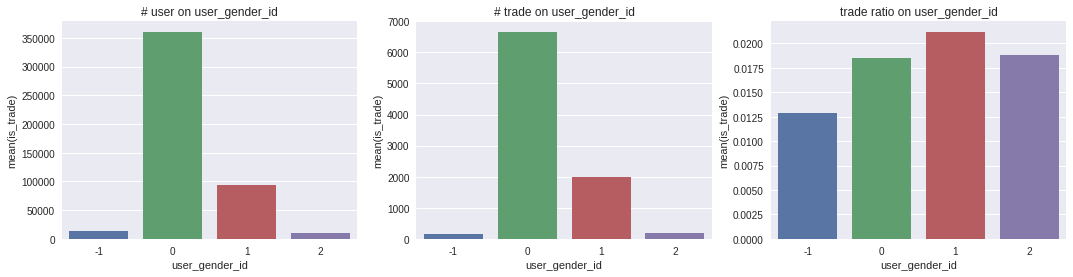

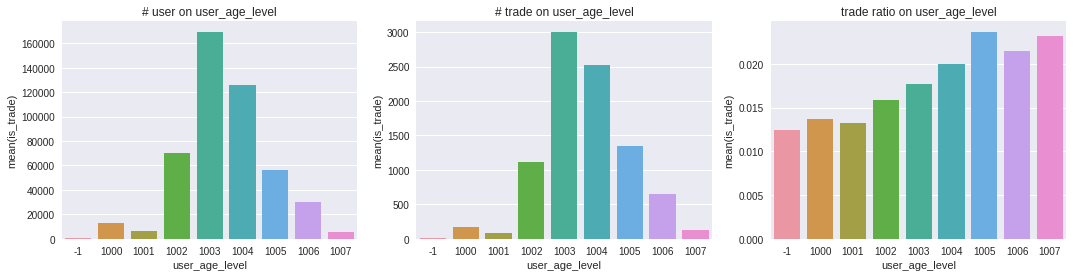

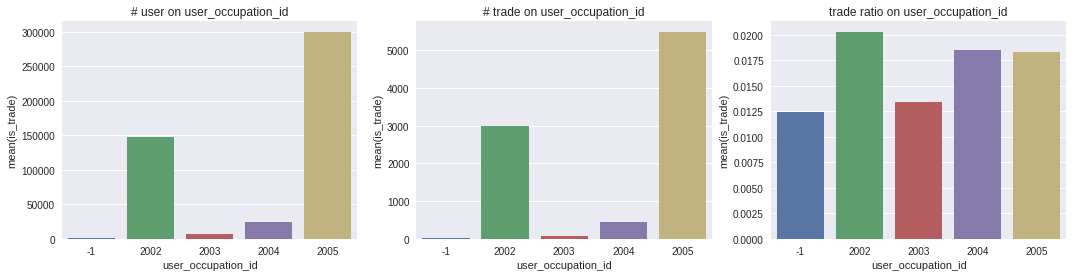

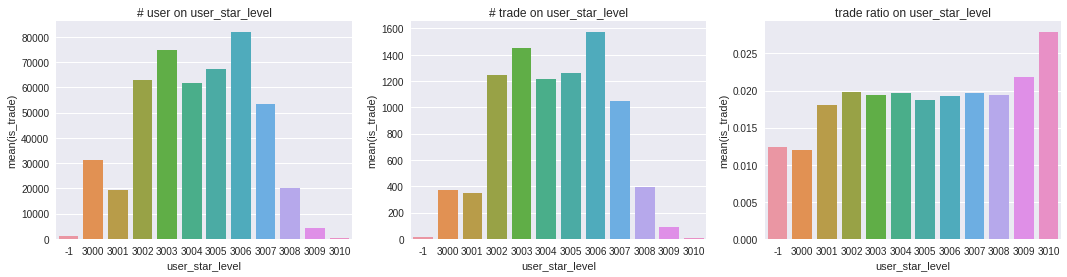

In [14]:
def counter_sumer_ratio(col, data):
  plt.figure(figsize=(18, 4))
  ax1=plt.subplot(131)
  ax2=plt.subplot(132)
  ax3=plt.subplot(133)
  ax1.set_title('# user on '+col)
  counter = data.groupby(col)[['is_trade']].count()
  sns.barplot(x=counter.index, y=counter['is_trade'], alpha=1, ax=ax1)
  ax2.set_title('# trade on '+col)
  sumer = data.groupby(col)[['is_trade']].sum()
  sns.barplot(x=sumer.index, y=sumer['is_trade'], alpha=1, ax=ax2)

  ax3.set_title('trade ratio on '+col)
  ratio = sumer / counter
  # print gender_ratio
  sns.barplot(x=ratio.index, y=ratio['is_trade'], ax=ax3)
  plt.show()


for col in ['user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level']:
  counter_sumer_ratio(col, eda_used)

In [0]:
def user_info_process(data):
  data['user_gender_id'] = data['user_gender_id'].map({-1:-1, 0:0, 1:1, 2:0}).astype(int)
  data['user_gender_id'] += 1
  
  data.loc[data['user_age_level']<1002, 'user_age_level'] = 0
  data.loc[data['user_age_level']>1003, 'user_age_level'] = 2
  data.loc[data['user_age_level']>1000, 'user_age_level'] = 1
  
  data['user_occupation_id'] = data['user_occupation_id'].map({-1:0, 2003:0, 2002:1, 2004:1, 2005:1}).astype(int)
  
  data.loc[data['user_star_level']<3001, 'user_star_level'] = 0
  data.loc[data['user_star_level']>3008, 'user_star_level'] = 2
  data.loc[data['user_star_level']>2999, 'user_star_level'] = 1
  
  return data

eda_used = user_info_process(eda_used)

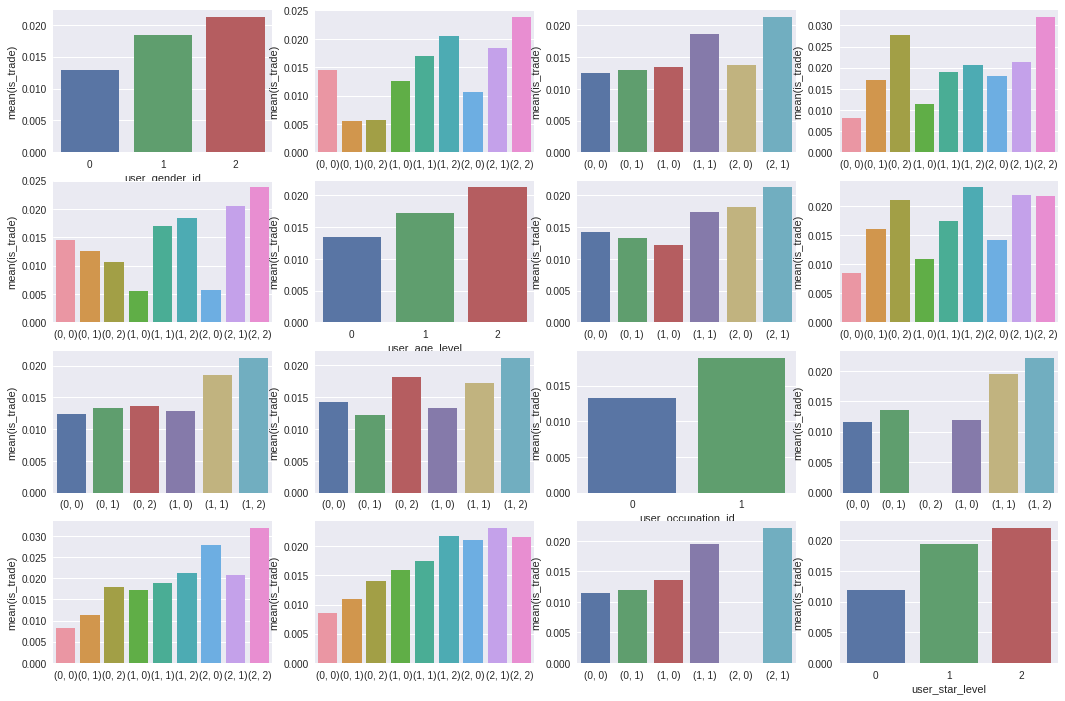

In [16]:
def check_cross_ratio(data):
  plotVars = ['user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level']
  plt.figure(figsize=(18, 12))
  for i in xrange(4):
    for j in xrange(4):
      ax = plt.subplot2grid((4, 4), (i, j))
  #     ax.axis('off')
      counter, sumer = None, None
      if i==j:
        counter = data.groupby(plotVars[i])[['is_trade']].count()
        sumer = data.groupby(plotVars[i])[['is_trade']].sum()
      else: 
        counter = data.groupby([plotVars[i], plotVars[j]])[['is_trade']].count()
        sumer = data.groupby([plotVars[i], plotVars[j]])[['is_trade']].sum()
      ratio = sumer/ counter
      sns.barplot(x=ratio.index, y=ratio['is_trade'], ax=ax)
  plt.show()
  
check_cross_ratio(eda_used)

count    207641.000000
mean          2.391190
std           2.364709
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          65.000000
Name: instance_count, dtype: float64
50


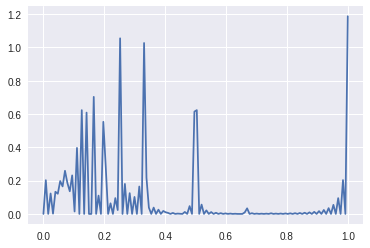

In [17]:
def process_on_concat(train, test, process, *args, **keys):
    concated = pd.concat([train.drop('is_trade', 1), test], axis=0)
    concated = process(concated, *args, **keys)

    train_part = concated[:train.shape[0]]
    train = pd.concat([train_part, train['is_trade']], axis=1)

    test = concated[train.shape[0]:]
    return train, test
  

def get_personal_info(data):
  ins_df = data.groupby('user_id', as_index=False)['instance_id'].agg({'instance_count': 'count'})  # the number of instance
  print ins_df['instance_count'].describe()
  print len(ins_df['instance_count'].unique())
  data = pd.merge(data, ins_df, on=['user_id'], how='left')
  return data


train_df, test_df = process_on_concat(train_df, test_df, get_personal_info)

trade_df = train_df.groupby('user_id', as_index=False)['is_trade'].agg({'trade_count': 'sum'})

train_df = pd.merge(train_df, trade_df, on=['user_id'], how='left')

trade_ratio_user = train_df['trade_count'] / train_df['instance_count']
sns.kdeplot(trade_ratio_user)
sns.plt.show()

####item information

category_0 1 ['7908382889764677758']


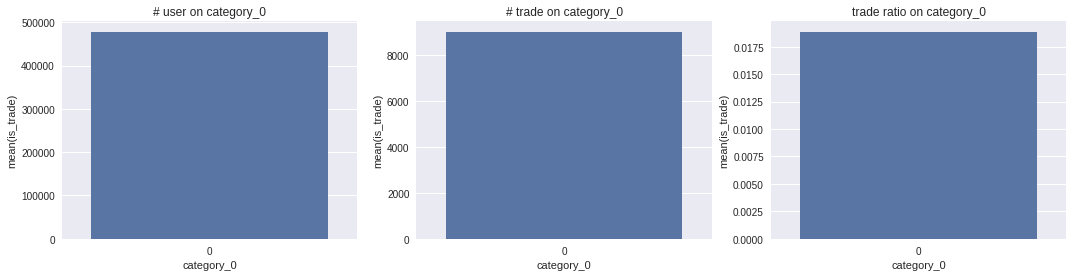

category_1 13 ['5799347067982556520' '8277336076276184272' '5755694407684602296'
 '4879721024980945592' '509660095530134768' '2436715285093487584'
 '7258015885215914736' '8710739180200009128' '2011981573061447208'
 '22731265849056483' '3203673979138763595' '2642175453151805566'
 '1968056100269760729']


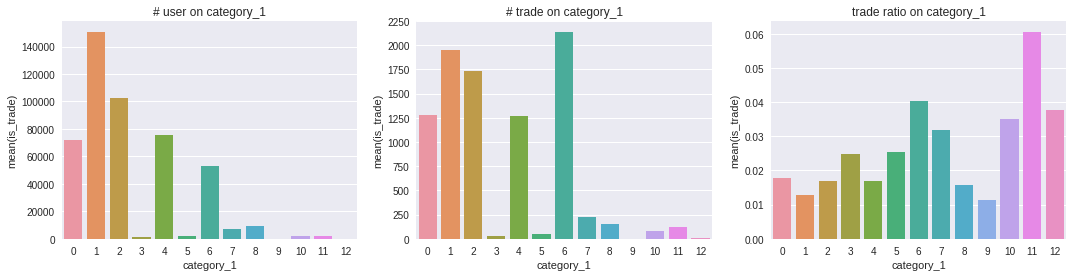

category_2 3 ['None' '8868887661186419229' '6233669177166538628']


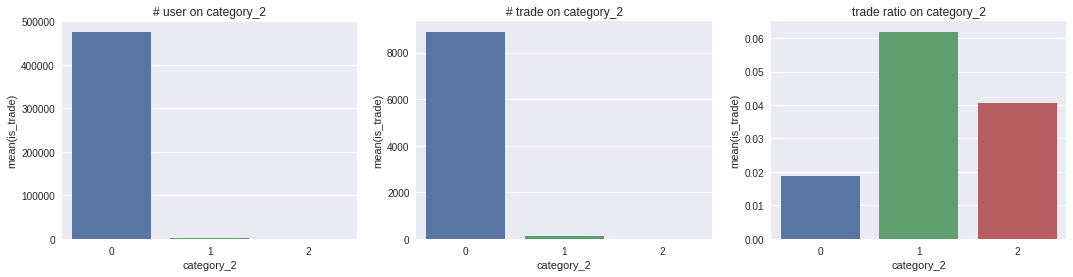

In [22]:
def get_category_list(data):
  data['category_0'] = data['item_category_list'].apply(lambda x: str(x).split(';')[0])
  data['category_1'] = data['item_category_list'].apply(lambda x: str(x).split(';')[1])
  data['category_2'] = data['item_category_list'].apply(lambda x: str(x).split(';')[2] if len(str(x).split(';'))>2 else 'None')
  del_list.append('item_category_list')
  return data


def get_property_list(data):
  property_len = data['item_property_list'].apply(lambda x: len(str(x).split(';')))
  print property_len.max()
  data['property_0'] = data['item_property_list'].apply(lambda x: str(x).split(';')[0])
  data['property_1'] = data['item_property_list'].apply(lambda x: str(x).split(';')[1])
  data['property_2'] = data['item_property_list'].apply(lambda x: str(x).split(';')[2] if len(str(x).split(';'))>2 else 'None')
  del_list.append('item_property_list')
  return data


eda_used = get_category_list(eda_used)
features = get_category_list(features)
for col in ['category_0', 'category_1', 'category_2']:
  values = features[col].unique()
  print col, len(values), values
  eda_used[col] = category_trans(eda_used[col])
  counter_sumer_ratio(col, eda_used)

In [23]:
eda_used = get_property_list(eda_used)
features = get_property_list(features)

total_values = []
for col in ['property_0', 'property_1', 'property_2']:
  values = features[col].unique()
  total_values.extend(values)
  print col, len(values)
#   eda_used[col] = category_trans(eda_used[col])
#   counter_sumer_ratio(col, eda_used)


print len(list(set(total_values)))

100
100
property_0 218
property_1 125
property_2 198
367


<type 'numpy.ndarray'>
[0 1 2]


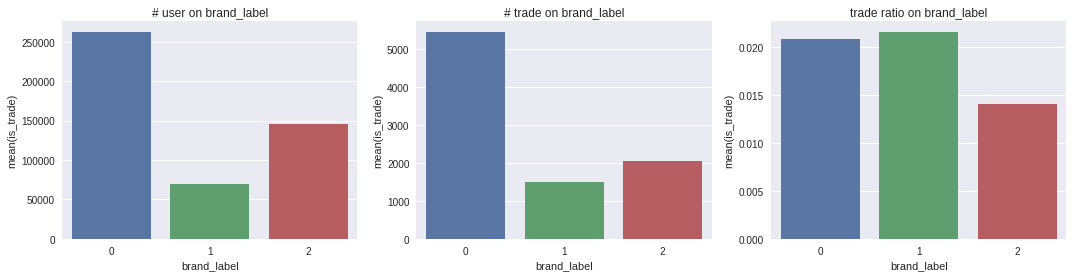

<type 'numpy.ndarray'>
[0 1 2 3 4]


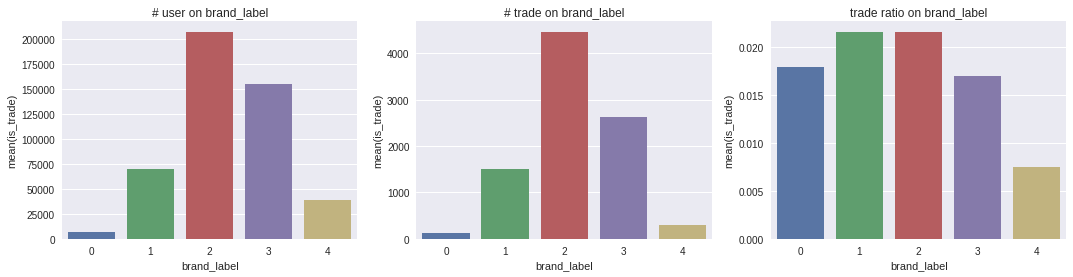

<type 'numpy.ndarray'>
[0 1 2 3 4 5 6]


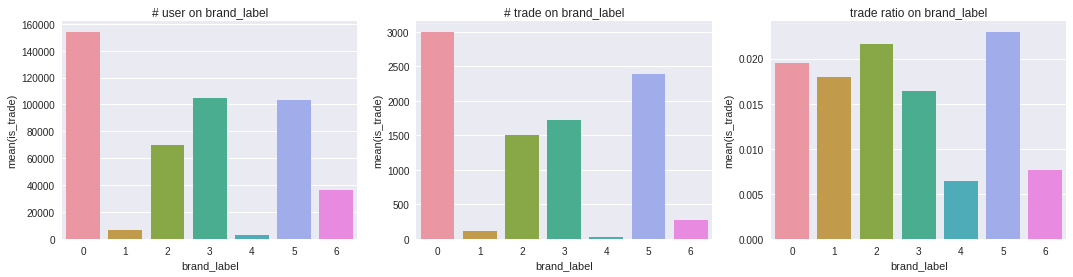

<type 'numpy.ndarray'>
[0 1 2 3 4 5 6 7 8]


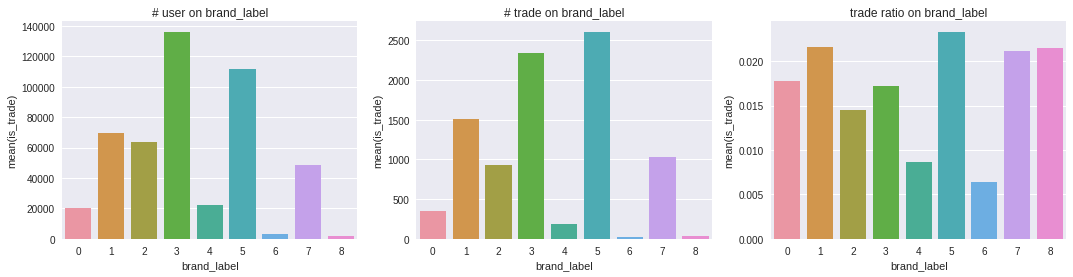

<type 'numpy.ndarray'>
[ 0  1  2  3  4  5  6  7  8  9 10]


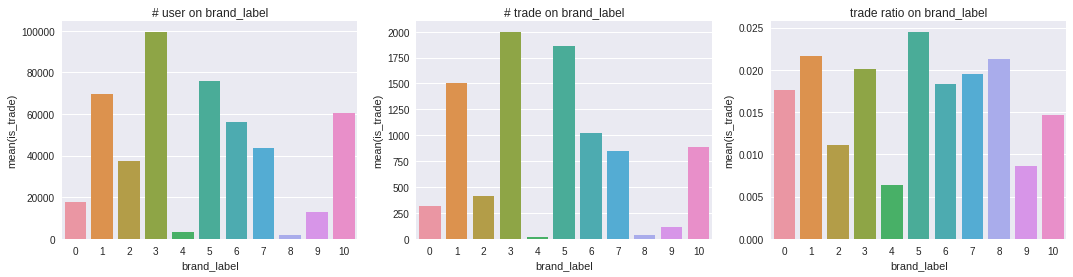

<type 'numpy.ndarray'>
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


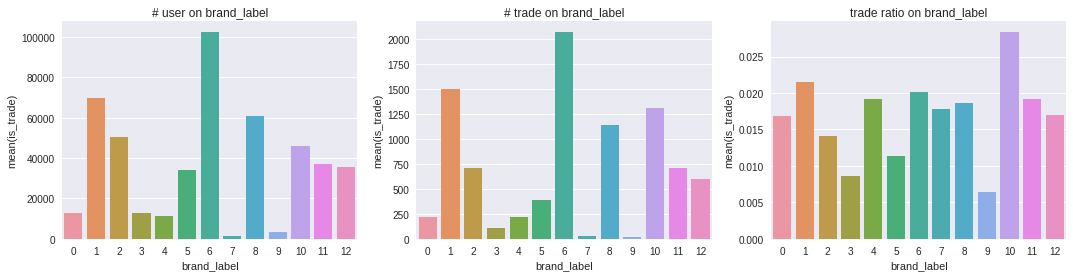

<type 'numpy.ndarray'>
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


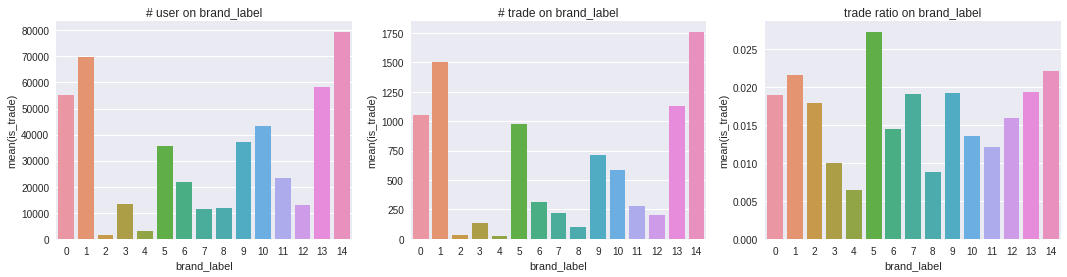

In [21]:
from sklearn.cluster import KMeans

def get_brand_info(data, clusters):
    # get the features of item brand
    nums_item = data.groupby('item_brand_id', as_index=False)['item_id'].agg(
        {'item_nums_brand': lambda x: len(x.unique())})
    nums_shop = data.groupby('item_brand_id', as_index=False)['shop_id'].agg(
        {'shop_nums_brand': lambda x: len(x.unique())})
    nums_ins = data.groupby('item_brand_id', as_index=False)['instance_id'].agg({'instance_nums_brand': 'count'})
    nums_user = data.groupby('item_brand_id', as_index=False)['user_id'].agg(
        {'user_nums_brand': 'count', 'fans_nums_brand': lambda x: len(x.unique())})
    # nums_trade = data.groupby('item_brand_id', as_index=False)['is_trade'].agg(
    # {'trade_ratio_brand': lambda x: x.sum()})
    avg_collected = data.groupby('item_brand_id', as_index=False)['item_collected_level'].agg(
        {'avg_collected_brand': lambda x: x.sum()/x.shape[0]})

    brand_info = None
    for tmp in [nums_item, nums_shop, nums_ins, nums_user, avg_collected]:
        if brand_info is None:
            brand_info = tmp
        else:
            brand_info = pd.merge(left=brand_info, right=tmp, how='left', on='item_brand_id')

    # brand_info.sort_values('trade_ratio_brand', ascending=False, inplace=True)
    brand_info['item_per_shop'] = brand_info['item_nums_brand'] / brand_info['shop_nums_brand']
    for col in brand_info.columns:
      if col not in['item_brand_id', 'item_per_shop']:
        mean = brand_info[col].mean()
        std = brand_info[col].std()
        brand_info[col] = (brand_info[col] - mean) / std
    brand_label = KMeans(n_clusters=clusters, random_state=10).fit_predict(brand_info.drop('item_brand_id', axis=1))
    print type(brand_label)
    print np.unique(brand_label)
    brand_info['brand_label'] = brand_label
    return brand_info

  
def test_cluster_num(data):
  for num in [3, 5, 7, 9, 11, 13, 15]:
    temp = data.copy()
    brand = get_brand_info(train_df, num)
    temp = pd.merge(left=temp, right=brand, how='left', on='item_brand_id')
    counter_sumer_ratio('brand_label', temp)
    
test_cluster_num(eda_used)

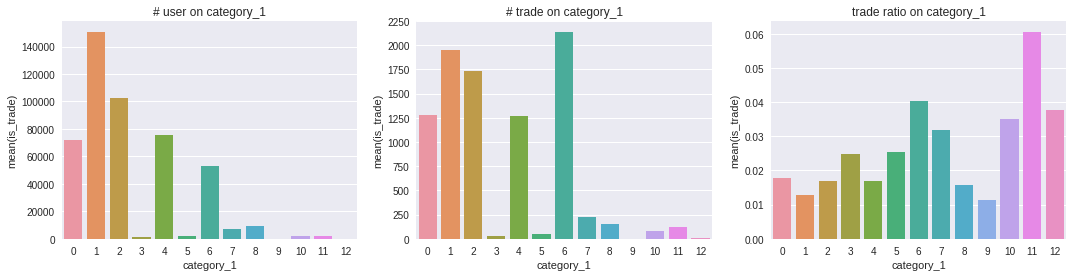

In [17]:
def item_info_process(data):
  data = get_category_list(data)
  
  data['category_2'] = data['category_2']==0
  data['category_1'].replace([3, 5, 8, 9], 3, inplace=True)
  data['category_1'].replace([7, 10, 11, 12], 7, inplace=True)
  data['category_1'] = category_trans(data['category_1'])
  return data

eda_used = item_info_process(eda_used)
counter_sumer_ratio('category_1', eda_used)

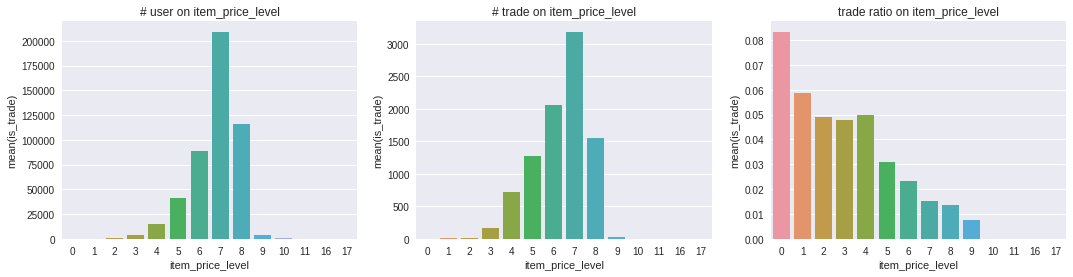

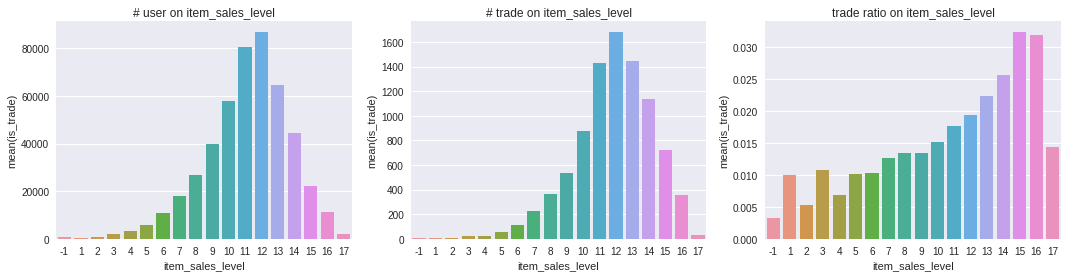

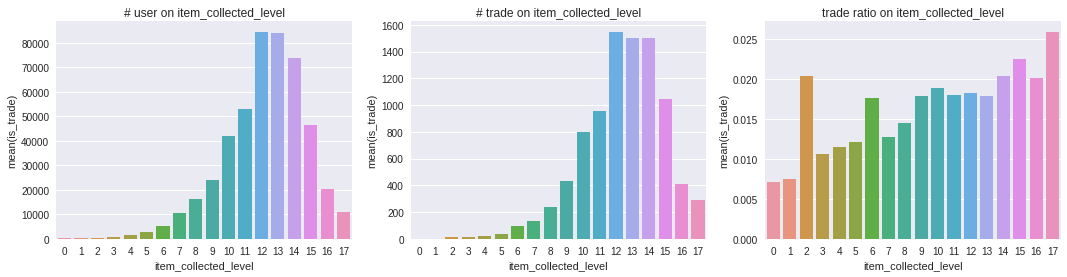

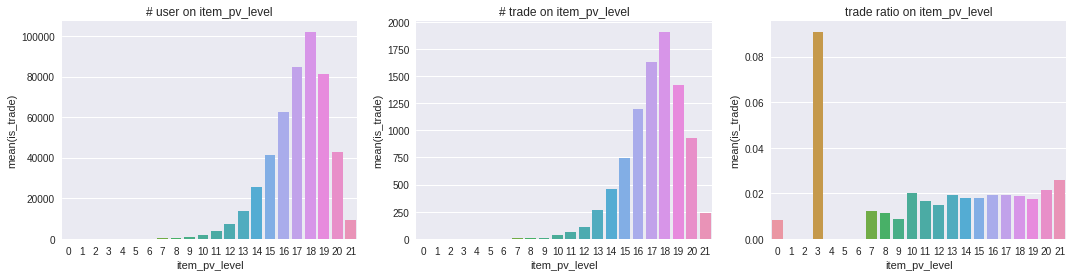

In [18]:
counter_sumer_ratio('item_price_level', eda_used)
counter_sumer_ratio('item_sales_level', eda_used)
counter_sumer_ratio('item_collected_level', eda_used)
counter_sumer_ratio('item_pv_level', eda_used)

In [0]:
def process_item_level(data):
  data['item_pv_level'] = data['item_pv_level'] > 6
  # normalization
  for col in ['item_price_level', 'item_sales_level', 'item_collected_level']:
    mean = data[col].mean()
    std = data[col].std()
    data[col] = (data[col] - mean) / std
  return data


eda_used = process_item_level(eda_used)

####shop information

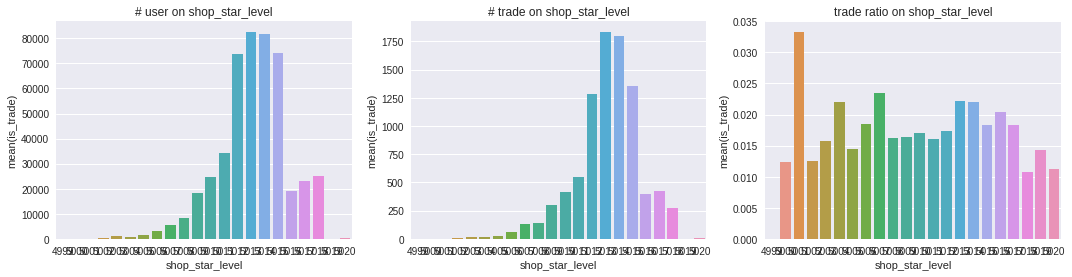

In [20]:
counter_sumer_ratio('shop_star_level', eda_used)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


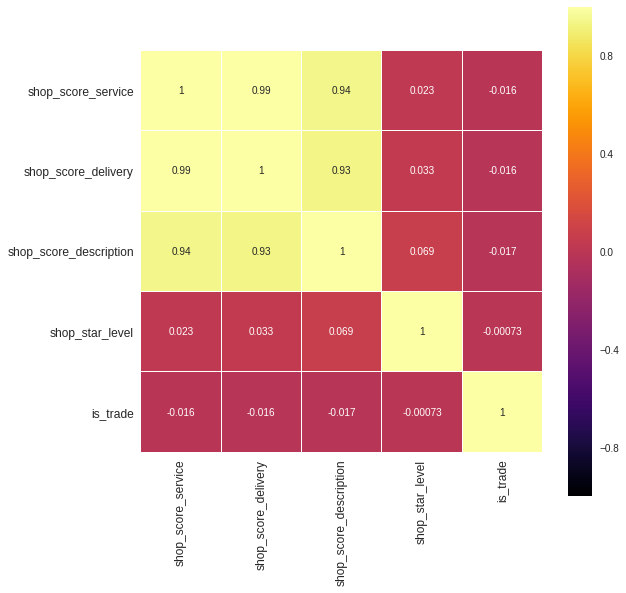

In [21]:
shop_score = eda_used[['shop_score_service', 'shop_score_delivery', 'shop_score_description', 'shop_star_level', 'is_trade']]
shop_score['shop_star_level'] = (shop_score['shop_star_level'] - shop_score['shop_star_level'].mean()) / shop_score['shop_star_level'].std()
corr = shop_score.corr()
f, ax = plt.subplots(figsize=(9,9))
sns.plt.yticks(fontsize=12)
sns.plt.xticks(fontsize=12)

sns.heatmap(corr, cmap='inferno', linewidths=0.1,vmax=1.0, square=True, annot=True)

###context information

[10 12  3  6 19 23 22 16  2 17 11 14  0 18 15 21  8 20  9 13  1  7  4  5]
24


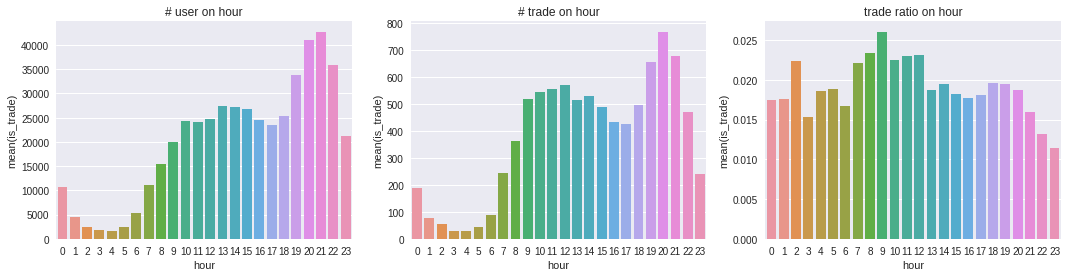

In [22]:
def timestamp_datetime(value):
    format = '%Y-%m-%d %H:%M:%S'
    value = time.localtime(value)
    dt = time.strftime(format, value)
    return dt

  
def extract_time(data):
  data['context_timestamp'] = data['context_timestamp'].apply(timestamp_datetime)
  data['context_timestamp'] = pd.to_datetime(data['context_timestamp'])
  data['hour'] = (data['context_timestamp'].dt.hour+8) % 24  # change to U TC+8
  return data  

eda_used = extract_time(eda_used)
# counter_sumer_ratio('hour', eda_used)
values = eda_used['hour'].unique()
print values
print len(values)
counter_sumer_ratio('hour', eda_used)

### predict_category_property

In [0]:
def predict_category_property_deal(data):
  data['property_len'] = data['predict_category_property'].apply(lambda x: len(x.split(',')))
  data['property_a'] = data['predict_category_property'].apply(lambda x: x.split(',')[0].split(';')[1])
  data['property_b'] = data['predict_category_property'].apply(lambda x: x.split(',')[1].split(';')[1])
  data['property_c'] = data['predict_category_property'].apply(lambda x: x.split(',')[3].split(';')[1])
  data.drop('predict_category_property', axis=1, inplace=True)
  return data